You're not actually using most of these packages (so, I commented them out)...

In [2]:
#from __future__ import division
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
#import statsmodels.api as sm
#import pylab as pl
#import numpy as np ## This is a duplicate

%matplotlib inline

In [7]:
#import Twitter data
df_raw_tweet = pd.read_csv('./Datasets/Twitter_Training_Data2.csv', encoding='latin1')
print (df_raw_tweet.head())

       Tweet id                                    Tweet_permalink  \
0  9.800000e+17  https://twitter.com/tippingpoint/status/979902...   
1  9.800000e+17  https://twitter.com/tippingpoint/status/979869...   
2  9.800000e+17  https://twitter.com/tippingpoint/status/979862...   
3  9.800000e+17  https://twitter.com/tippingpoint/status/979767...   
4  9.790000e+17  https://twitter.com/tippingpoint/status/979457...   

                                          Tweet_text        Attribute  \
0  Thank you to our #TippingPointGrantees! It's a...  Event Promotion   
1  .@NewTeacherCtr's newly released program stand...        Education   
2  The majority of our chronically homeless neigh...     Homelessness   
3  Congratulations to AD-10 Woman of the Year Luc...      Immigration   
4  Thanks for the shout out @New_Sincerity! Our i...       Nonprofits   

                     time  impressions  engagements  url clicks  
0  2018-03-31 02:05 +0000          980            9           5  
1  2018-

In [ ]:
#import FB data
df_raw_fb = pd.read_csv('./Datasets/Facebook_Training_Data.csv', encoding='latin1')
print (df_raw_fb.head())

#### Split into test/training groups

In [8]:
# Randomly select 90% of df rows
msk = np.random.rand(len(df_raw_tweet)) < 0.9

# Assign those to the training set
df_train = df_raw_tweet[msk] 

# Assign the remainder to the test set
df_test = df_raw_tweet[~msk]

# Check and make sure they are the right size
print('Training set size: ' + str(len(df_train)))
print('Test set size: ' + str(len(df_test)))

Training set size: 238
Test set size: 29


In [9]:
# this is what I tried to do and it works but I'm not sure if it's the correct way to create an object
tweet_train_data = df_train['Tweet_text'].tolist()
tweet_train_target = df_train['Attribute'].tolist()

tweet_test_data = df_test['Tweet_text'].tolist()
tweet_test_target = df_test['Attribute'].tolist()

### Extracting features with Bag-of-words

Tokenizing text

In [12]:
# Load package
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate model
count_vect = CountVectorizer()

# Train model (fit and transform)
X_train_counts = count_vect.fit_transform(tweet_train_data)
X_train_counts.shape

(238, 1811)

### From occurrences to frequencies

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer

tf_transformer = TfidfTransformer(use_idf=False) # instantiate
tf_transformer.fit(X_train_counts) # fit our estimator to the data
X_train_tf = tf_transformer.transform(X_train_counts) # transform our count-matrix to a tf-idf representation

# Or condense the previous two steps into one:
tfidf_transformer = TfidfTransformer() # instantiate
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts) # fit AND transform

print(X_train_tfidf.shape)

(238, 1811)


### Training a classifier
Now that we have our features, we can train a classifier to try to predict the category of a post. Let’s start with a naïve Bayes classifier, which provides a nice baseline for this task.

In [14]:
# Load package
from sklearn.naive_bayes import MultinomialNB

# Instantiate and fit the classifier model
clf = MultinomialNB().fit(X_train_tfidf, tweet_train_target)

To try to predict the outcome on a new document we need to extract the features using `transform` instead of `fit_transform` on the transformers, since they have already been fit to the training set:

In [15]:
docs_new = ['God is love', 'Education are great']
X_new_counts = count_vect.transform(tweet_test_data)
X_new_tfidf = tf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category, truth in zip(tweet_test_data, predicted, tweet_test_target):
    print('%r => %s [Actually: %s]' % (doc, category, truth))

"For your Sunday listening - Dr. Nadine Burke Harris of @CYWSanFrancisco shares her expertise on managing trauma and stress to minimize their impact on children's long-term health. #TippingPointGrantees #BeATippingPoint\rhttps://t.co/HsTGrYfxnF" => Homelessness [Actually: Early Childhood]
'What a night! Thank you @TheBonnieRaitt for bringing our community together at @foxoakland to support #NorthBayFire relief. #BeATippingPoint\rhttps://t.co/9IL7JZO5of' => Fire Relief [Actually: Event Promotion]
'At its core, the homelessness crisis results from a lack of affordable housing. @CityLab + @NLIHC reveal the extent of the problem across all 50 states:\rhttps://t.co/g16BxjGc5J' => Homelessness [Actually: Homelessness]
'Ã¢â\x82¬Å\x93...the hope is: We built these systems. We can build new ones.Ã¢â\x82¬Ã¹\r@c4innovates CEO @jeffolivet cautiously optimistic as he discusses a recent study underlining the relationship between structural racism and homelessness.\rhttps://t.co/OctNc9uc1K' => Homele

So, we've created a 'Homelessness' (and to a much lesser extent, 'Education') detector that happens to be right a lot. This isn't surprising given the disproportionate number of homelessness tweets in the training set.
All the parts are in place now, why don't you play with it a bit? It would be good to add a metric to quantify accuracy more precisely (just see class NBs for examples). Once that is in place, start making tweaks to try and improve it. It might not be a bad idea to try and add more training samples.

### Building a pipeline

In [16]:
from sklearn.pipeline import Pipeline

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])

In [17]:
text_clf.fit(tweet_train_data, tweet_train_target)  

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

### Evaluation of the performance on the test set

In [18]:
import numpy as np

df_test = df_raw_tweet[~msk]
docs_test = tweet_test_data
predicted = text_clf.predict(docs_test)
np.mean(predicted == tweet_test_target) 

0.3793103448275862

In [19]:
from sklearn.linear_model import SGDClassifier

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, random_state=42,
                                           max_iter=5, tol=None)),
])
text_clf.fit(tweet_train_data, tweet_train_target)  
predicted = text_clf.predict(docs_test)
np.mean(predicted == tweet_test_target)  

0.5862068965517241

In [31]:
from sklearn import metrics

print(metrics.classification_report(tweet_test_target, predicted))

metrics.confusion_matrix(tweet_test_target, predicted)

                                  precision    recall  f1-score   support

Corporate Social Responsibility        0.00      0.00      0.00         0
                 Early Childhood       1.00      1.00      1.00         2
                       Education       0.67      0.50      0.57         4
                 Event Promotion       0.00      0.00      0.00         1
                     Fire Relief       0.71      0.83      0.77         6
                    Homelessness       0.75      0.86      0.80         7
                     Immigration       0.50      1.00      0.67         1
                      Nonprofits       0.00      0.00      0.00         0
                        Poverty        0.00      0.00      0.00         1
                            Race       0.33      0.33      0.33         3
corporate Social Responsibility        0.00      0.00      0.00         1
                      employment       0.00      0.00      0.00         1
                 event Promotion     

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 6, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Confusion matrix, without normalization
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 1 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 6 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0]]
Normalized confusion matrix
[[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.5  0.   0.   0.   0.   0.25 0.   0.25 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.83 0.   0.   0.   0.   0.17 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.86 0.14 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


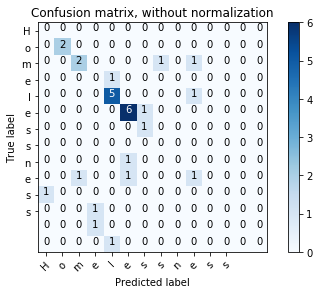

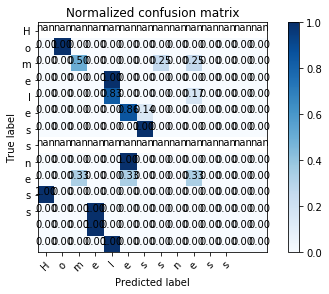

In [34]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, category,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(category))
    plt.xticks(tick_marks, category, rotation=45)
    plt.yticks(tick_marks, category)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(tweet_test_target, predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, category,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, category, normalize=True,
                      title='Normalized confusion matrix')

plt.show()